## Exploratory Data Analysis (EDA) 
### Multi-Agent Reinforcement Learning in Supply Chain Optimization

**Author:** Thomas Hazenberg  
**Email:** thomas.hazenberg@student.uva.nl  
**Date:** 23 March 2024  
**GitHub Repository:** https://github.com/thomashz246/Master-Thesis

---

Other related datasets:
- Supply Chain Management (https://www.kaggle.com/datasets/lastman0800/supply-chain-management)
- M5 Forecasting (https://www.kaggle.com/competitions/m5-forecasting-accuracy/data?select=sell_prices.csv)

---

### Data Loading & Initial Exploration

To begin our analysis, we load the dataset using **Pandas**.  
Since the dataset contains textual data, we specify the `latin1`  **encoding** to ensure compatibility with special characters.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

df = pd.read_csv("Data/DataCo Smart Supply Chain/DataCoSupplyChainDataset.csv", encoding='latin1')

---

### Corpus-Level Analysis

Before diving into detailed analysis, we inspect the dataset structure:
- **Shape:** Number of rows and columns
- **Info:** Data types and missing values
- **Head:** First 5 rows for an overview of the dataset

In [ ]:
print("Dataset Shape:", df.shape)
print("-------------------------")
display(df.info())
print("-------------------------")
display(df.head(5))

---

### Checking for Missing Values

Identifying missing values helps decide on the necessary data cleaning steps.

In [ ]:
# Checking for missing values
print("Missing values per column:")
print(df.isnull().sum()[df.isnull().sum() > 0])

Previously `df.info()` and now `df.isnull().sum()` shows us that (almost) every feature/column has full non-null values except for **Product Description**. Also **Order Zipcode** only has 24.840 non-null values. Because they lack enough values, these features will be dropped.* The few values missing for **Customer Lname** and **Customer Zipcode** will not be dropped for this EDA but could later be dropped due to feature relevance.

###### *The relevancy of these features to the research of building an environment for multi-agent reinforcement learning is low, as they do not contribute meaningful information to agent-based decision-making or optimization strategies in a reinforcement learning framework. The **Product Description** column is purely textual and does not provide numerical or categorical insights relevant to modeling agent interactions, while **Order Zipcode** is highly sparse and likely does not add significant predictive value in the context of supply chain optimization or decision-making for multi-agent environments.

---

### Dropping empty columns and check for duplicates

Columns that have too many `NaN`-values are dropped and we check if there are duplicate rows in the dataset.

In [ ]:
# Dropping entirely or almost empty columns
df.drop(columns=["Product Description"], inplace=True)
df.drop(columns=["Order Zipcode"], inplace=True)

# Checking for duplicates
print(f"Number of duplicate rows: {df.duplicated().sum()}")

### Converting Date Columns to Datetime Format

Ensuring date columns are in proper datetime format allows for time-based analysis.

In [ ]:
df["order date (DateOrders)"] = pd.to_datetime(df["order date (DateOrders)"], errors='coerce')
df["shipping date (DateOrders)"] = pd.to_datetime(df["shipping date (DateOrders)"], errors='coerce')

## Univariate Analysis

---

### Summary Statistics

Generating summary statistics for numerical columns to understand distributions and ranges.

In [ ]:
# Summary statistics
display(df.describe())

### Histograms

Visualizing distributions of numerical features to understand spread and skewness.

In [ ]:
plt.figure(figsize=(12, 10))
df.hist(figsize=(12, 10), bins=50)
plt.show()

### Boxplots

Boxplots help detect outliers and understand feature ranges.

In [ ]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=df.select_dtypes(include=['float64', 'int64']))
plt.xticks(rotation=90)
plt.show()

### KDE Plots

Kernel Density Estimation (KDE) plots show probability distributions of numerical features. When there is a low number of unique values, a bar plot is chosen instead of a KDE one.

In [ ]:
for column in df.select_dtypes(include=['float64', 'int64']).columns:
    plt.figure(figsize=(8, 4))

    unique_values = df[column].nunique()

    if unique_values > 10:  
        sns.kdeplot(df[column], fill=True)
        plt.title(f"KDE Plot of {column}")
    elif unique_values > 1: 
        sns.barplot(x=df[column].value_counts().index, 
                    y=df[column].value_counts().values)
        plt.xlabel(column)
        plt.ylabel("Count")
        plt.title(f"Bar Plot of {column}")
    else:
        print(f"Skipping {column}")
    
    plt.show()

## Baseline Model - Order Profit Distribution

To establish a baseline, we first analyze the distribution of the target variable (`Order Profit Per Order`).  
Understanding this distribution helps identify potential skewness, outliers, and necessary transformations.  
Additionally, we compute a simple baseline model by predicting the **mean order profit** and measuring its performance using **Mean Absolute Error (MAE)**.

Distribution of Order Profit Per Order:


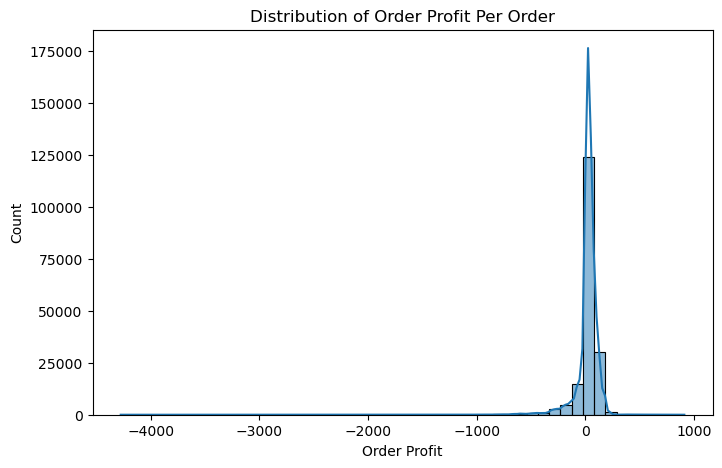

In [10]:
# Baseline Model - Target Variable (Order Profit)
print("Distribution of Order Profit Per Order:")
plt.figure(figsize=(8, 5))
sns.histplot(df['Order Profit Per Order'], bins=50, kde=True)
plt.title("Distribution of Order Profit Per Order")
plt.xlabel("Order Profit")
plt.ylabel("Count")
plt.show()

In [11]:
# Baseline Model - Predicting with Mean Order Profit
baseline_prediction = df['Order Profit Per Order'].mean()

# Compute Mean Absolute Error (MAE) as a baseline metric
baseline_mae = np.mean(np.abs(df['Order Profit Per Order'] - baseline_prediction))

print(f"Baseline Prediction (Mean Order Profit): {baseline_prediction:.2f}")
print(f"Baseline MAE: {baseline_mae:.2f}")

Baseline Prediction (Mean Order Profit): 21.97
Baseline MAE: 56.09


## Multivariate Analysis
---
### Feature Correlation

Understanding relationships between variables using a correlation heatmap.

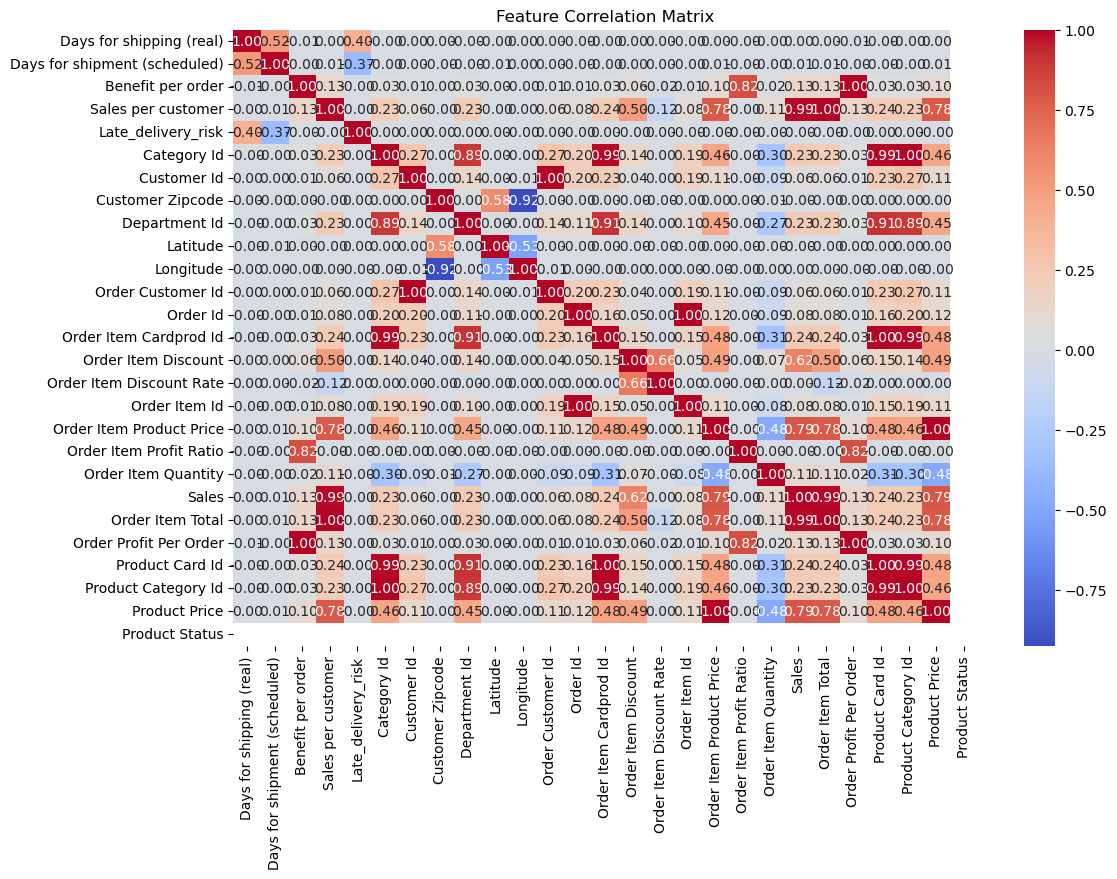

In [13]:
# Select only numeric columns for correlation
numeric_df = df.select_dtypes(include=['number'])

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(numeric_df.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature Correlation Matrix")
plt.show()

### Pairplot

Pairplots help us visualize relationships and potential patterns between key numerical variables. The features `Sales`, `Order Item Total`, `Order Profit Per Order` and `Order Item Quantity` are chosen for their relevance in this research

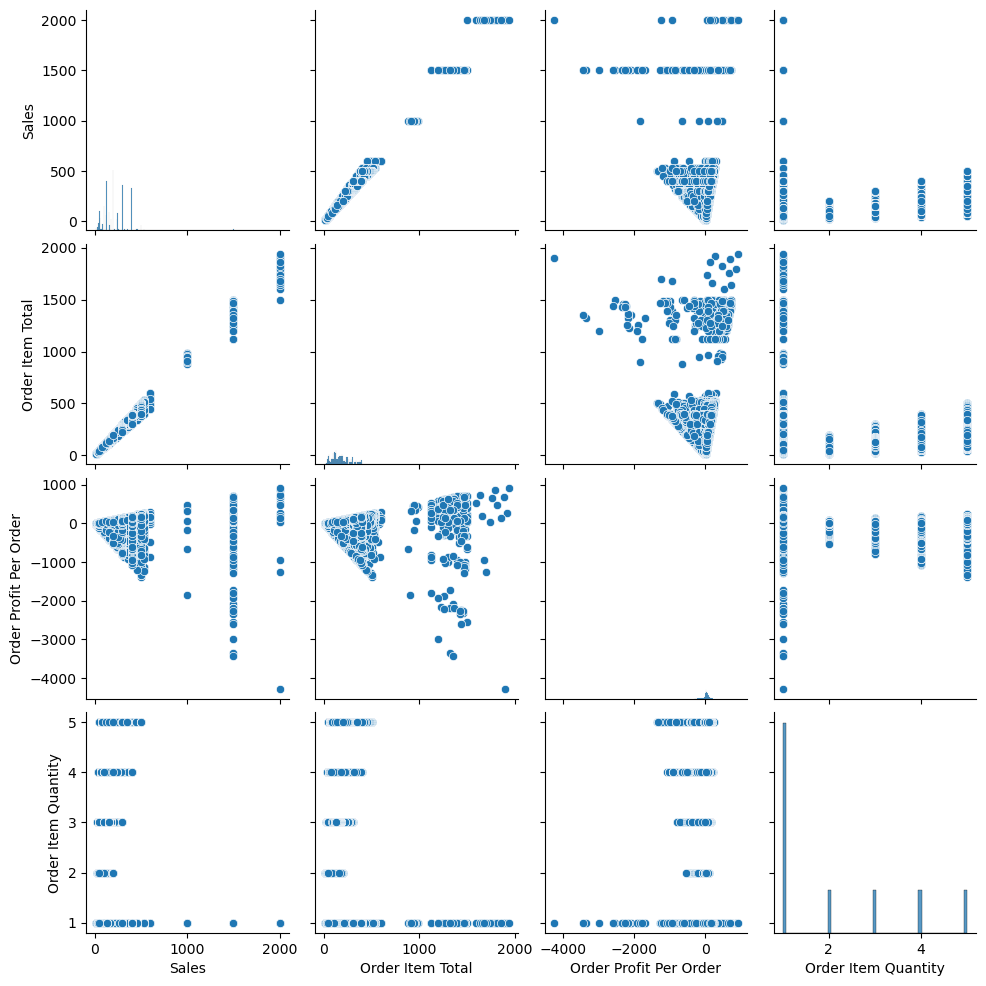

In [20]:
selected_features = ['Sales', 'Order Item Total', 'Order Profit Per Order', 'Order Item Quantity']
sns.pairplot(df[selected_features])
plt.show()

### Data Cleaning - Handling Missing Values

Filling missing values using the median ensures the dataset remains balanced and avoids bias.

In [16]:
df[df.select_dtypes(include=['float64', 'int64']).columns] = \
    df.select_dtypes(include=['float64', 'int64']).apply(lambda x: x.fillna(x.median()))

### Data Normalization - Standardization

Standardization ensures all features are on a similar scale, improving model performance.

In [17]:
scaler = StandardScaler()
df_scaled = df.copy()
df_scaled[df.select_dtypes(include=['float64', 'int64']).columns] = scaler.fit_transform(df[df.select_dtypes(include=['float64', 'int64']).columns])

### Categorical Variable Analysis

In addition to numerical variables, categorical variables can provide valuable insights. We analyze how different categories impact the target variable (`Order Profit Per Order`). This is done by grouping and averaging them. 

In [19]:
category_features = ['Shipping Mode', 'Customer Segment']
for feature in category_features:
    print(f"Mean Order Profit grouped by {feature}:\n", df.groupby(feature)['Order Profit Per Order'].mean())
    print("\n")

Mean Order Profit grouped by Shipping Mode:
 Shipping Mode
First Class       23.122238
Same Day          20.850203
Second Class      21.305889
Standard Class    21.999169
Name: Order Profit Per Order, dtype: float64


Mean Order Profit grouped by Customer Segment:
 Customer Segment
Consumer       22.175390
Corporate      21.949204
Home Office    21.437359
Name: Order Profit Per Order, dtype: float64


